In [1]:
# in this notebook we explore the best phi_pre for both strategies. 
import itertools
import numpy as np
import random
import pickle
import matplotlib.pyplot as plt
from math import *
import scipy
from tqdm import tqdm
import copy
import seaborn as sns

from utils import *
from lag_test_utils import *
from scipy.optimize import root_scalar

import matplotlib as mpl
import pandas as pd

# Set the default font and size
# mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.size'] = 14

In [8]:
# for each run, generate 1000 diauxers with different phi pre; check the average phi_pre of the survivors in this run in each timepoint
T_dilute = 24
STEADY_CRIT = 1e-6
MAX_CYCLE = 5e3
MIN_RHO = 1e-200
gmean, gsigma, gC, R, D = 0.5, 0.1, 1.0, 4, 1000
tau_init_dist = lambda x: np.random.uniform(2, 3)
tau_0_dist = lambda x: np.random.uniform(0.2, 0.4)
rho_dist = lambda x: 10**np.random.uniform(-4, -1)*4

Nseq = 10
g_seq = generate_g(Nseq, R, gmean, gsigma)
permutations = list(itertools.permutations(list(range(1, R+1))))
pref_list = np.array(random.choices(permutations, k=Nseq))
col = np.argmax(g_seq, axis=1) # find column in g where it's the largest
for row_i, row in enumerate(pref_list):
    index = np.where(row==col[row_i]+1)[0][0] # and switch this resource with the first-consumed one
    row[0], row[index] = row[index], row[0]
species_list = []
for i in range(Nseq):
    species_list.append(SeqUt_alt(rho=rho_dist(i), g_enz=g_seq[i], gC=gC, pref_list=pref_list[i], biomass=0.01, id=i))

# assign lags to all the species
for species in species_list:
    tau0 = tau_0_dist(0)
    tau_init = tau_init_dist(0)
    if(species.cat=="Seq"):
        species.SetLag(tau0, TaufSeq, tau_init)
        species.b = 0.01

Rs = np.ones(R)
# run the assembly
C = EcoSystem([])
history = []
b_list, id_list = [], []
for idx, species in tqdm(enumerate(species_list)):
    if(C.CheckInvade(species, D)):
        C.Invade(species)
        steady = False
        count = 0
        while count < MAX_CYCLE and steady == False:
            count += 1
            C.OneCycle(Rs, T_dilute)
            b_list.append(C.last_cycle['bs'][-1])
            id_list.append(C.last_cycle['ids'])
            if(len(b_list)>1 and len(b_list[-1])==len(b_list[-2])):
                b_diff = np.abs((b_list[-1]-b_list[-2])/b_list[-1])
                if(np.max(b_diff)<STEADY_CRIT):
                    steady = True
            C.MoveToNext(D)
        history.append([idx, C.last_cycle])

10it [00:56,  5.67s/it]


In [9]:
C.last_cycle

{'ids': [2, 4, 5],
 'ts': [0,
  2.32958912627386,
  2.5141731862412797,
  2.5757688362439572,
  11.555951761151531,
  11.90456134126018,
  12.090824451999858,
  12.836632797074419,
  13.487517274734365,
  13.863237345088312,
  24.0],
 'cs': [array([1., 1., 1., 1.]),
  array([1., 1., 1., 1.]),
  array([1.        , 1.        , 1.        , 0.99981526]),
  array([0.9999354 , 1.        , 1.        , 0.99974832]),
  array([0.21524148, 0.        , 1.        , 0.30298601]),
  array([0.        , 0.        , 1.        , 0.11809614]),
  array([0., 0., 1., 0.]),
  array([0., 0., 1., 0.]),
  array([0.        , 0.        , 0.58016433, 0.        ]),
  array([0., 0., 0., 0.]),
  array([0., 0., 0., 0.])],
 'bs': [array([0.00147882, 0.00113004, 0.00139514]),
  array([0.00147882, 0.00113004, 0.00139514]),
  array([0.00147882, 0.00113004, 0.00157988]),
  array([0.00154342, 0.00113004, 0.00164682]),
  array([0.78623734, 1.00113004, 0.69840913]),
  array([1.00147882, 1.00113004, 0.883299  ]),
  array([1.001

In [77]:
def MakeSlots(k, M, min_ratio=0.5):
    slots = []
    start = 1
    width = 1
    while True:
        end = start + width
        # Ensure we don't overshoot M
        if end > M:
            # Adjust the last slot to end exactly at M
            if (M - start) / width < min_ratio:
                # If it's too narrow, merge with the previous slot
                slots[-1][1] = M
            else:
                slots.append([start, M])
            break
        slots.append([start, end])
        # Update for next slot
        start = end
        width *= k
    return slots
# def MakeSlots(start, end, num_points):
#     # Define log-space range, avoiding log(0) by starting slightly above zero
#     log_start = np.log10(max(start, 1e-10))  # to avoid log(0) issue
#     log_end = np.log10(end)
#     log_points = np.linspace(log_start, log_end, num_points)
#     points = 10 ** log_points
#     slots = [[points[i], points[i + 1]] for i in range(len(points) - 1)]
#     return slots

def FindSlot(slots, number):
    for i, (start, end) in enumerate(slots):
        if start <= number < end:
            return i
    return None 

100%|████████████████████████████████████████| 100/100 [00:00<00:00, 159.71it/s]


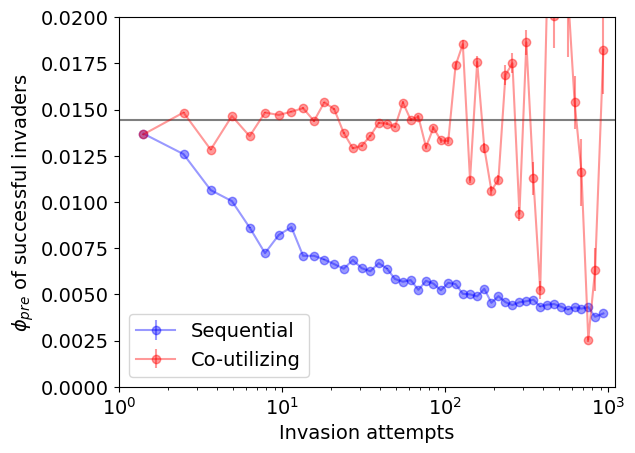

In [91]:
# check the results from running phi_pre.py
# check the results from running phi_pre.py
pool_type = "mix"
n_comm = 100
Nseq = 500
rhos_data_seq = {}
rhos_data_cout = {}
for comm in tqdm(range(n_comm)):
    inputs = pickle.load(open(f"../data/phi_pre/type={pool_type}_{comm}.pkl", "rb"))
    for item in inputs:
        for idx, i in enumerate(item["invasions"]):
            invader = []
            if(idx==0):
                invader = item["survivors"][0]
            if(item["survivors"][idx]!=item["survivors"][idx-1]):
                invader = list(set(item["survivors"][idx]) - set(item["survivors"][idx-1]))
            if(invader!=[]):
                invader = invader[0]
                if(invader<Nseq):
                    if(i not in rhos_data_seq):
                        rhos_data_seq[i] = []
                    rhos_data_seq[i].append(item["rhos"][idx]/4)
                else:
                    if(i not in rhos_data_cout):
                        rhos_data_cout[i] = []
                    rhos_data_cout[i].append(item["rhos"][idx]/4)
# xs = []
# ys = []
# for i in range(1000):
#     if(i in rhos_data_seq.keys()):
#         xs.append(i)
#         ys.append(np.mean(rhos_data_seq[i]))
# plt.scatter(xs, ys)
# plt.xscale("log")

slots = MakeSlots(1.1, 1001) # right end use 1000+1 to avoid conflict
xs = [sqrt(i[0]*i[1]) for i in slots]
ys = [[] for i in xs]
for i in range(1000):
    if(i in rhos_data_seq.keys()):
        idx = FindSlot(slots, i+1)
        ys[idx].extend(rhos_data_seq[i])

plt.errorbar(xs, [np.mean(i) for i in ys], yerr=[np.std(i)/len(i) for i in ys], marker="o", color="b", alpha=0.4, label="Sequential")
plt.xscale("log")
plt.ylim(0, 0.02)

xs = [sqrt(i[0]*i[1]) for i in slots]
ys = [[] for i in xs]
for i in range(1000):
    if(i in rhos_data_cout.keys()):
        idx = FindSlot(slots, i+1)
        ys[idx].extend(rhos_data_cout[i])

plt.errorbar(xs, [np.mean(i) for i in ys], yerr=[np.std(i)/len(i) for i in ys], marker="o", color="r", alpha=0.4, label="Co-utilizing")
plt.xscale("log")
plt.ylim(0, 0.02)
plt.xlim(1, 1100)
plt.legend(loc="lower left")
plt.xlabel("Invasion attempts")
plt.ylabel("$\\phi_{pre}$ of successful invaders")
mu = (1e-1 - 1e-4)/(3*log(10))
plt.axhline(mu, color="k", alpha=0.5)
plt.show()

100%|████████████████████████████████████████| 100/100 [00:00<00:00, 334.27it/s]


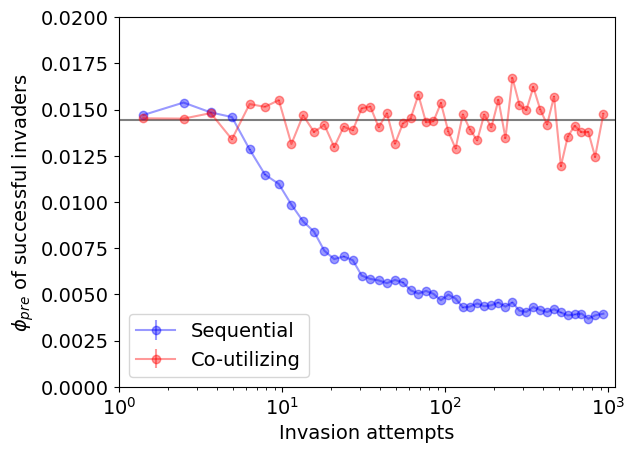

In [90]:
# check the results from running phi_pre.py
pool_type = "seq"
n_comm = 100
Nseq = 1000
rhos_data_seq = {}
rhos_data_cout = {}
for comm in tqdm(range(n_comm)):
    inputs = pickle.load(open(f"../data/phi_pre/type={pool_type}_{comm}.pkl", "rb"))
    for item in inputs:
        for idx, i in enumerate(item["invasions"]):
            invader = []
            if(idx==0):
                invader = item["survivors"][0]
            if(item["survivors"][idx]!=item["survivors"][idx-1]):
                invader = list(set(item["survivors"][idx]) - set(item["survivors"][idx-1]))
            if(invader!=[]):
                invader = invader[0]
                if(invader<Nseq):
                    if(i not in rhos_data_seq):
                        rhos_data_seq[i] = []
                    rhos_data_seq[i].append(item["rhos"][idx]/4)
                else:
                    if(i not in rhos_data_cout):
                        rhos_data_cout[i] = []
                    rhos_data_cout[i].append(item["rhos"][idx]/4)

# xs = []
# ys = []
# for i in range(1000):
#     if(i in rhos_data_seq.keys()):
#         xs.append(i)
#         ys.append(np.mean(rhos_data_seq[i]))
# plt.scatter(xs, ys)
# plt.xscale("log")

slots = MakeSlots(1.1, 1001) # right end use 1000+1 to avoid conflict
xs = [sqrt(i[0]*i[1]) for i in slots]
ys = [[] for i in xs]
for i in range(1000):
    if(i in rhos_data_seq.keys()):
        idx = FindSlot(slots, i+1)
        ys[idx].extend(rhos_data_seq[i])

plt.errorbar(xs, [np.mean(i) for i in ys], yerr=[np.std(i)/len(i) for i in ys], marker="o", color="b", alpha=0.4, label="Sequential")
plt.xscale("log")
plt.ylim(0, 0.02)

# check the results from running phi_pre.py
pool_type = "cout"
n_comm = 100
Nseq = 0
rhos_data_seq = {}
rhos_data_cout = {}
for comm in tqdm(range(n_comm)):
    inputs = pickle.load(open(f"../data/phi_pre/type={pool_type}_{comm}.pkl", "rb"))
    for item in inputs:
        for idx, i in enumerate(item["invasions"]):
            invader = []
            if(idx==0):
                invader = item["survivors"][0]
            if(item["survivors"][idx]!=item["survivors"][idx-1]):
                invader = list(set(item["survivors"][idx]) - set(item["survivors"][idx-1]))
            if(invader!=[]):
                invader = invader[0]
                if(invader<Nseq):
                    if(i not in rhos_data_seq):
                        rhos_data_seq[i] = []
                    rhos_data_seq[i].append(item["rhos"][idx]/4)
                else:
                    if(i not in rhos_data_cout):
                        rhos_data_cout[i] = []
                    rhos_data_cout[i].append(item["rhos"][idx]/4)

slots = MakeSlots(1.1, 1001) # right end use 1000+1 to avoid conflict
xs = [sqrt(i[0]*i[1]) for i in slots]
ys = [[] for i in xs]
for i in range(1000):
    if(i in rhos_data_cout.keys()):
        idx = FindSlot(slots, i+1)
        ys[idx].extend(rhos_data_cout[i])

plt.errorbar(xs, [np.mean(i) for i in ys], yerr=[np.std(i)/len(i) for i in ys], marker="o", color="r", alpha=0.4, label="Co-utilizing")
plt.xscale("log")
plt.ylim(0, 0.02)
plt.xlim(1, 1100)
plt.legend(loc="lower left")
plt.xlabel("Invasion attempts")
plt.ylabel("$\\phi_{pre}$ of successful invaders")
mu = (1e-1 - 1e-4)/(3*log(10))
plt.axhline(mu, color="k", alpha=0.5)
plt.show()

In [87]:
# mean of dist
(1e-1 - 1e-4)/(3*log(10))

0.014462006247378286